In [ ]:
sgRNA = """
EIF2B4 pDS491
DNAJC19 pDS026
EIF2B2 pDS463
EIF2B3 pDS508
TIMM44 pDS430
SLMO2 pDS433
HSPA9 pDS088
IARS2 pDS090
IARS2 pDS091
AARS pDS381
EIF2S1 pDS386
CARS pDS460
QARS pDS510
HARS pDS466
FARSB pDS390
SARS pDS467
DARS pDS495
MARS pDS394
TARS pDS405
DNAJC19 pDS074
MRPL39 pDS498
TIMM23 pDS284
ATP5B pDS055
SAMM50 pDS156
TTI2 pDS408
TELO2 pDS496
TTI1 pDS407
CAD pDS468
CCND3 pDS006
PSMD4 pDS488
MRGBP pDS124
PTDSS1 pDS478
SRPRB pDS404
SRPR pDS482
GNPNAT1 pDS506
SRP72 pDS505
NegCtrl-2 pBA580
XRN1 pDS411
HYOU1 pDS089
NegCtrl-3 pBA582
SPCS2 pDS401
MANF pDS027
PDIA6 pDS029
SRP68 pDS403
SEC61G pDS440
SEC61A1 pDS031
SEC61A1 pDS032
COPB1 pDS065
COPZ1 pDS462
ARHGAP22 pDS458
IDH3A pDS393
ASCC3 pDS051
ASCC3 pDS052
CHERP pDS024
PPWD1 pDS398
FECH pDS494
MTHFD1 pDS395
NEDD8 pDS396
P4HB pDS397
DERL2 pDS042
HSD17B12 pDS087
SOCS1 pDS479
HSPA5 pDS017
HSPA5 pDS371
TMEM167A pDS038
IER31P1 pDS110
YIPF5 pDS186
YIPF5 pDS226
IER31P1 pDS002
SCYL1 pDS159
SCYL1 pDS160
DHDDS pDS383
SPCS3 pDS402
GBF1 pDS043
AMIGO3 pDS434
GMPPB pDS391
SEL1L pDS373
SYVN1 pDS442
SLC35B1 pDS046
STT3A pDS011
SEC63 pDS218
SLC39A7 pDS219
SEC61B pDS033
SEC61B pDS162
TMED10 pDS036
TMED2 pDS175
DDRGK1 pDS041
UFL1 pDS410
UFM1 pDS040
DAD1 pDS499
DDOST pDS382
KCTD16 pDS096
OST4 pDS353
""".replace(" ", "_").split("\n")[1:-1]

# Test PCA

In [ ]:
all_adatas

{'GSM2406675_10X001': AnnData object with n_obs × n_vars = 5768 × 35635
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406677_10X005': AnnData object with n_obs × n_vars = 15006 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406681_10X010': AnnData object with n_obs × n_vars = 65337 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment'}

In [ ]:
adata = all_adatas["GSM2406677_10X005"].copy()

In [ ]:
# filter out cell with guide identity that account for less than 2% (those are artifacts)
adata = adata[
    adata.obs["guide identity"].isin(
        adata.obs["guide identity"]
        .value_counts(normalize=True, dropna=False)
        .loc[lambda x: x > 0.02]
        .index
    )
].copy()

In [ ]:
annot37 = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "external_gene_name"],
    host="grch37.ensembl.org"
).set_index("ensembl_gene_id")

adata.var["gene_name"] = annot37.loc[adata.var_names]
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var["gene_name"].str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var["gene_name"].str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var["gene_name"].str.contains("^HB[^(P)]")

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], percent_top=[20], inplace=True, log1p=True
)

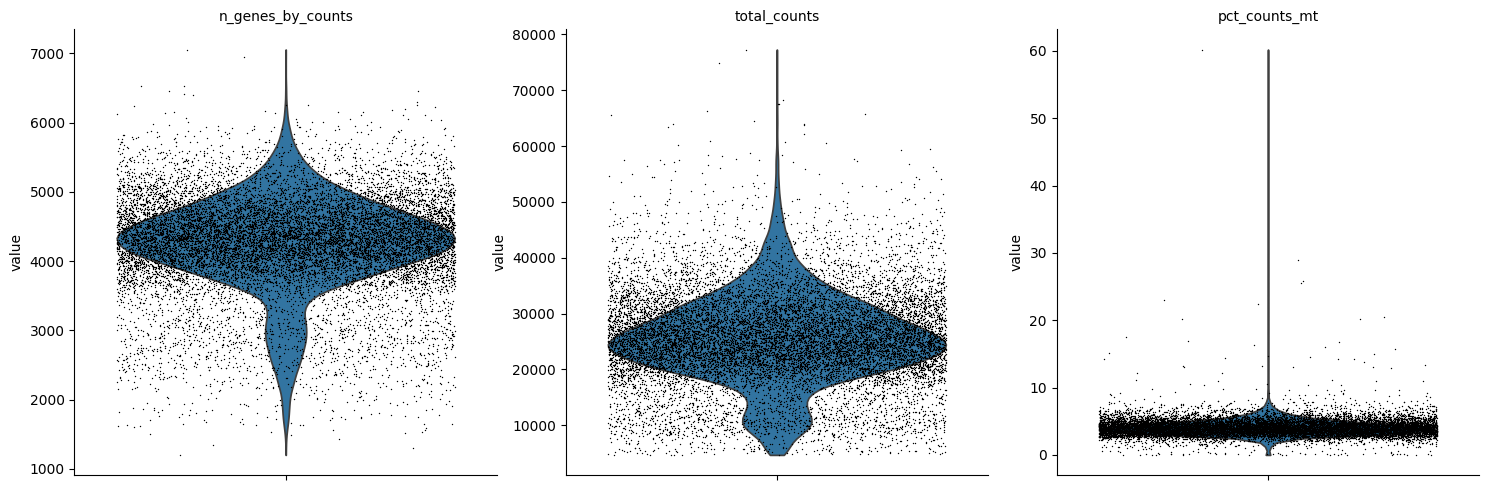

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],#, "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

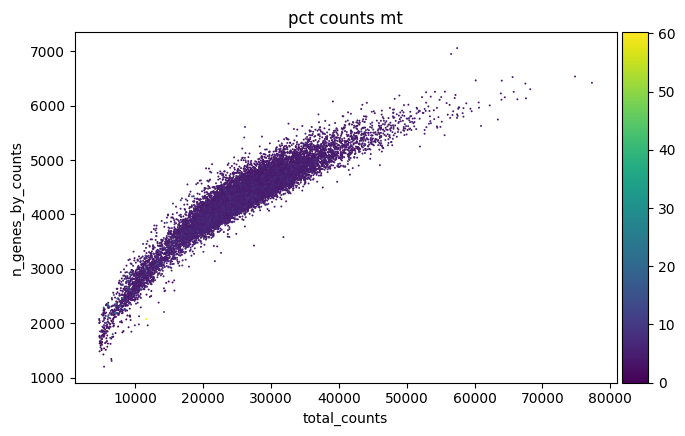

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print(adata.obs.outlier.value_counts())

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
print(adata.obs.mt_outlier.value_counts())

In [ ]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 14776
Number of cells after filtering of low quality cells: 13039


In [ ]:
# Careful, those perturbation: map to those actual genes
# IRE1 -> ERN1  and PERK -> EIF2AK3
map_gene_target = {"IRE1": "ERN1", "PERK": "EIF2AK3"}

def parse_guide(g):
    parts = [p for p in g.split("_") if p != "only"]
    if len(parts) == 1:
        parts *= 2
    raw_target = "_".join(parts[:-1])
    mapped_parts = [map_gene_target.get(p, p) for p in parts]
    target = "_".join(mapped_parts[:-1])
    plasmid = mapped_parts[-1]
    return {
        "raw_target": raw_target,
        "target": target,
        "plasmid": plasmid
    }

map_guide_id = {
    g: parse_guide(str(g)) for g in adata.obs["guide identity"].unique()
}


In [ ]:
adata.obs = adata.obs.join(
    adata.obs["guide identity"].astype(str).to_frame().join(
        pd.DataFrame(map_guide_id).T,
        on="guide identity"
    ).drop(columns=["guide identity"])
)

In [ ]:
sc.pp.filter_genes(adata, min_cells=20)

In [ ]:
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [ ]:
adata.obs["batch_possible"] = adata.obs_names.to_series().str.split("-").apply(lambda x: x[-1]).astype("category")

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=6000, batch_key="batch_possible")

/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


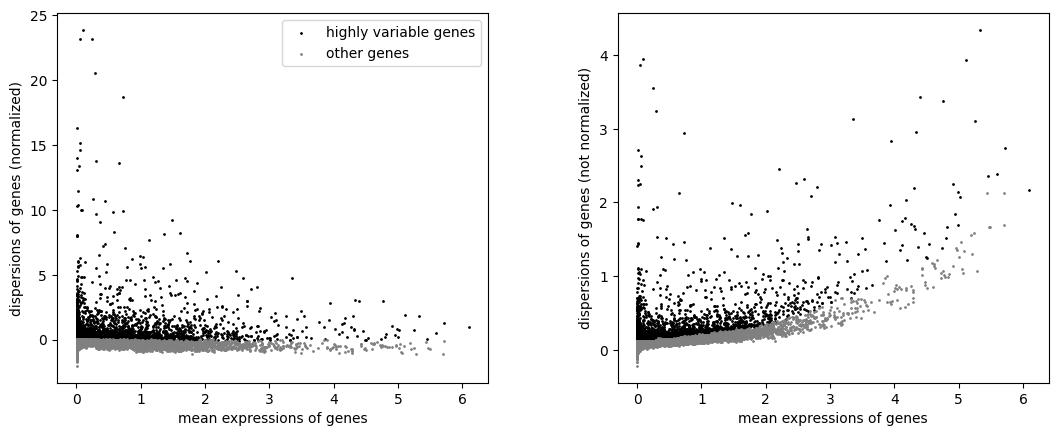

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata = adata[:, adata.var["highly_variable"]].copy()

In [ ]:
sc.tl.pca(adata)

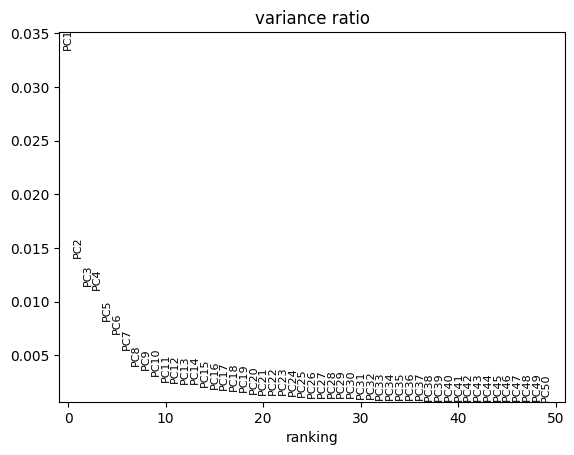

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False)

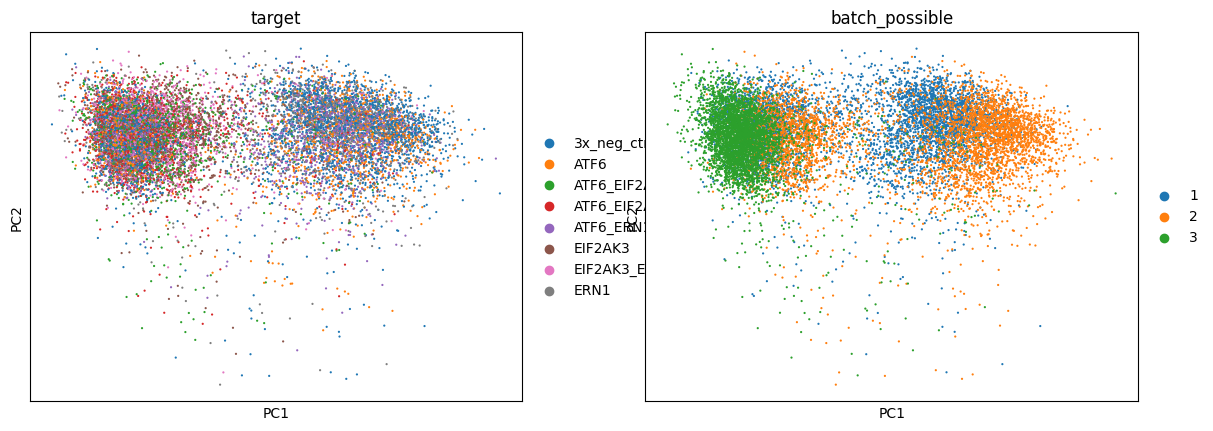

In [ ]:
sc.pl.pca(
    adata,
    color=["target", "batch_possible"],
    dimensions=[(0, 1), (0, 1)],
    ncols=2,
    size=10,
)

In [ ]:
adata

AnnData object with n_obs × n_vars = 13039 × 6000
    obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'raw_target', 'target', 'plasmid', 'batch_possible'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'target_colors', 'batch_possible_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [ ]:
sc.pp.neighbors(adata)

In [ ]:
sc.tl.umap(adata)

In [ ]:
adata

AnnData object with n_obs × n_vars = 13039 × 6000
    obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'raw_target', 'target', 'plasmid', 'batch_possible'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'target_colors', 'batch_possible_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts

In [ ]:
adata.obs.groupby(["batch_possible", "target"]).size().unstack(fill_value=0)

/tmp/ipykernel_226973/2764563519.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["batch_possible", "target"]).size().unstack(fill_value=0)


target,3x_neg_ctrl,ATF6,ATF6_EIF2AK3,ATF6_EIF2AK3_ERN1,ATF6_ERN1,EIF2AK3,EIF2AK3_ERN1,ERN1
batch_possible,,,,,,,,
1,1113,533,490,537,472,500,520,510
2,1006,506,471,514,433,455,495,514
3,892,459,434,470,376,433,433,473


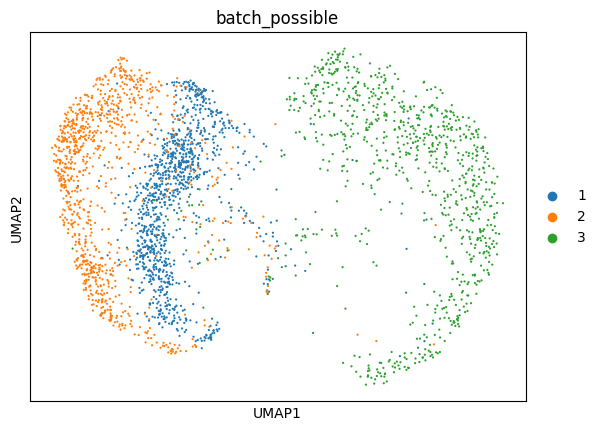

In [ ]:
sc.pl.umap(
    adata[adata.obs["target"].str.count("ctrl") > 0],
    color="batch_possible",
    # Setting a smaller point size to get prevent overlap
    size=10,
)

# Test Pertpy

In [ ]:
adata_pertpy = pt.data.adamson_2016_upr_epistasis()

In [ ]:
adata_pertpy.var

,ensembl_id,ncounts,ncells
gene_symbol,,,
MIR1302-10,ENSG00000243485,2.0,2
FAM138A,ENSG00000237613,0.0,0
OR4F5,ENSG00000186092,0.0,0
RP11-34P13.7,ENSG00000238009,1.0,1
RP11-34P13.8,ENSG00000239945,2.0,2
...,...,...,...
AC145205.1,ENSG00000215635,0.0,0
BAGE5,ENSG00000268590,0.0,0
CU459201.1,ENSG00000251180,0.0,0


In [ ]:
adata.obs["replicate"] = adata.obs_names.to_series().str.split("-").apply(lambda x: x[1])
adata.obs["condition"] = (adata.obs["target"].astype(str)+ "-" + adata.obs["replicate"].astype(str) ).astype("category")

In [ ]:
all_adatas

{'GSM2406675_10X001': AnnData object with n_obs × n_vars = 5768 × 35635
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406677_10X005': AnnData object with n_obs × n_vars = 15006 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment',
 'GSM2406681_10X010': AnnData object with n_obs × n_vars = 65337 × 32738
     obs: 'guide identity', 'read count', 'UMI count', 'coverage', 'good coverage', 'number of cells', 'experiment'}

# Correlation matrix for UPR Perturb Seq experiement

In [ ]:
adata = all_adatas["GSM2406681_10X010"].copy()
adata.obs = adata.obs.rename(columns={"guide identity": "perturbation"})
annot37 = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "external_gene_name"],
    host="grch37.ensembl.org"
).set_index("ensembl_gene_id")
adata.var["gene_symbol"] = annot37.loc[adata.var_names]
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var["gene_symbol"].str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var["gene_symbol"].str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var["gene_symbol"].str.contains("^HB[^(P)]")

In [ ]:
file = pooch.retrieve(
    url="https://ars.els-cdn.com/content/image/1-s2.0-S0092867416316609-mmc1.xlsx",
    known_hash="sha256:9b5935cb15ba2f6d60d3017832de2918e7d4f172db6f202be7999cba5feea82b"
)
protospace_df = pd.read_excel(file, header=1)
protospace_df["Gene"] = protospace_df["Gene"].apply(lambda x: x.split("/") if isinstance(x, str) else x)
protospace_df = protospace_df.explode("Gene").reset_index(drop=True)

/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
adata = adata[(
    (pert := adata.obs["perturbation"]).isin(
        (protospace_df["Gene"] + "_" + protospace_df["Perturb-seq_Vector_ID"]).dropna()) |
    (pert.str.contains("mod") & pert.isin(pert.value_counts()[pert.value_counts() > 100].index))
)].copy()

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], percent_top=[20], inplace=True, log1p=True
)

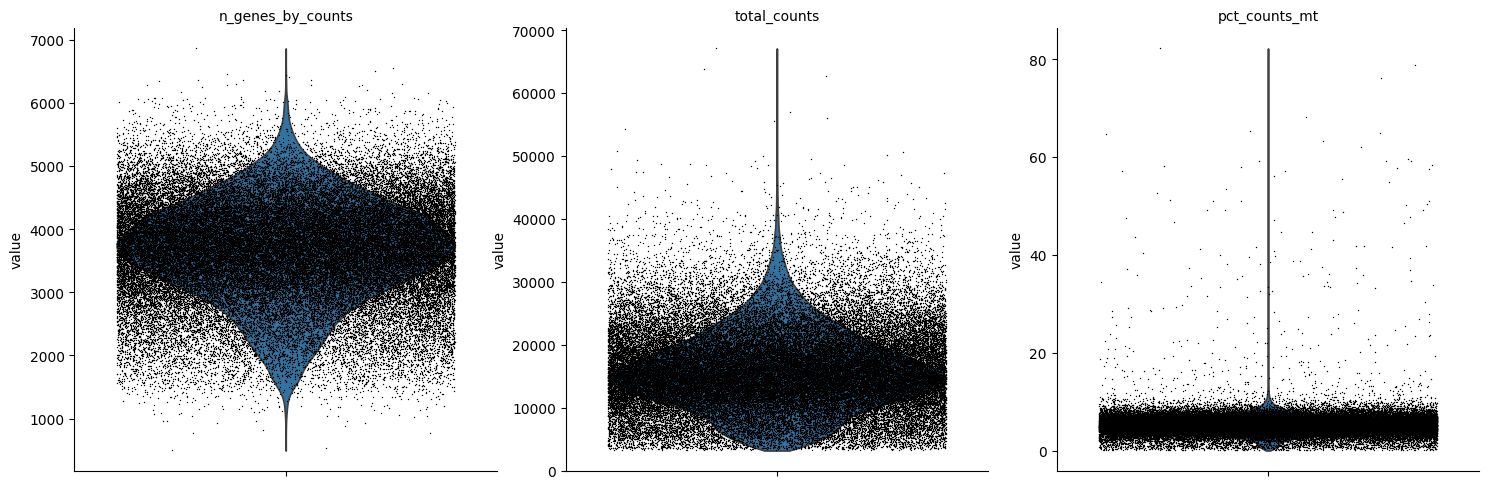

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [ ]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print(adata.obs.outlier.value_counts())

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
print(adata.obs.mt_outlier.value_counts())

outlier
False    62086
True      1953
Name: count, dtype: int64
mt_outlier
False    58537
True      5502
Name: count, dtype: int64


In [ ]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 64039
Number of cells after filtering of low quality cells: 57418


In [ ]:
# Careful, those perturbation: map to those actual genes
# IRE1 -> ERN1  and PERK -> EIF2AK3
map_gene_target = {"IRE1": "ERN1", "PERK": "EIF2AK3"}

def parse_guide(g):
    parts = [p for p in g.split("_") if p != "only"]
    if len(parts) == 1:
        parts *= 2
    raw_target = "_".join(parts[:-1])
    mapped_parts = [map_gene_target.get(p, p) for p in parts]
    target = "+".join(mapped_parts[:-1])
    plasmid = mapped_parts[-1]
    return {
        "raw_target": raw_target,
        "target": target,
        "plasmid": plasmid
    }

map_guide_id = {
    g: parse_guide(str(g)) for g in adata.obs["perturbation"].unique()
}


In [ ]:
adata.obs = adata.obs.join(
    adata.obs["perturbation"].astype(str).to_frame().join(
        pd.DataFrame(map_guide_id).T,
        on="perturbation"
    ).drop(columns=["perturbation"])
)
adata.obs["target"] = adata.obs["target"].where(~adata.obs["target"].str.contains("mod"), "control")
adata.obs["target"] = adata.obs["target"].astype("category")

In [ ]:
adata.layers["count"] = adata.X

In [ ]:
sc.pp.normalize_total(adata)
adata.layers["normalized"] = adata.X

In [ ]:
ctrl_mask = adata.obs["target"].str.contains("control")
ctrl_mean = adata[ctrl_mask].X.toarray().mean(axis=0)
ctrl_std = adata[ctrl_mask].X.toarray().std(axis=0)
ctrl_std = np.where(ctrl_std == 0, 1, ctrl_std)
adata.layers["z_norm_ctrl"] = (adata.X - ctrl_mean) / ctrl_std


/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: Layer 'z_norm_ctrl' should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [ ]:
ctrl_adata = adata[ctrl_mask]#.copy()
perturb_adata = adata[~ctrl_mask]#.copy()

In [ ]:
selected_genes = (
    (ctrl_adata.layers["count"].mean(axis=0) > 0.5 * ctrl_adata.obs["UMI count"].mean()) |
    (perturb_adata.layers["count"].mean(axis=0) > 0.5 * perturb_adata.obs["UMI count"].mean()) |
    (perturb_adata.layers["z_norm_ctrl"].mean(axis=0) > 0.5)
)

In [ ]:
adata_selected_genes = adata[:,selected_genes.A1].copy()
adata_selected_genes.X = adata_selected_genes.layers["z_norm_ctrl"]

In [ ]:
import pandas as pd
import numpy as np

# Make sure selected_genes is a list of gene names present in adata.var_names
adata = adata_selected_genes  # just to be clear

# Subset to selected genes and expression layer
X = adata_selected_genes.X

# Create a DataFrame with target labels
targets = adata.obs["target"].values

# Create a DataFrame of expression (cells x genes)
expr_df = pd.DataFrame(X, columns=adata.var["gene_symbol"])

# Add target as a column
expr_df["target"] = targets

# Group by target and average (mean = pseudo-bulk)
pseudobulk_expr = expr_df.groupby("target").mean()

# Optional: reindex if you want targets in a specific order
pseudobulk_expr = pseudobulk_expr.sort_index()
adata_pseudobulk = ad.AnnData(
    X=pseudobulk_expr.values,
    obs=pd.DataFrame(index=pseudobulk_expr.index),       # target groups as observations
    var=pd.DataFrame(index=pseudobulk_expr.columns) # genes as variables
)

/tmp/ipykernel_334154/895345986.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_expr = expr_df.groupby("target").mean()


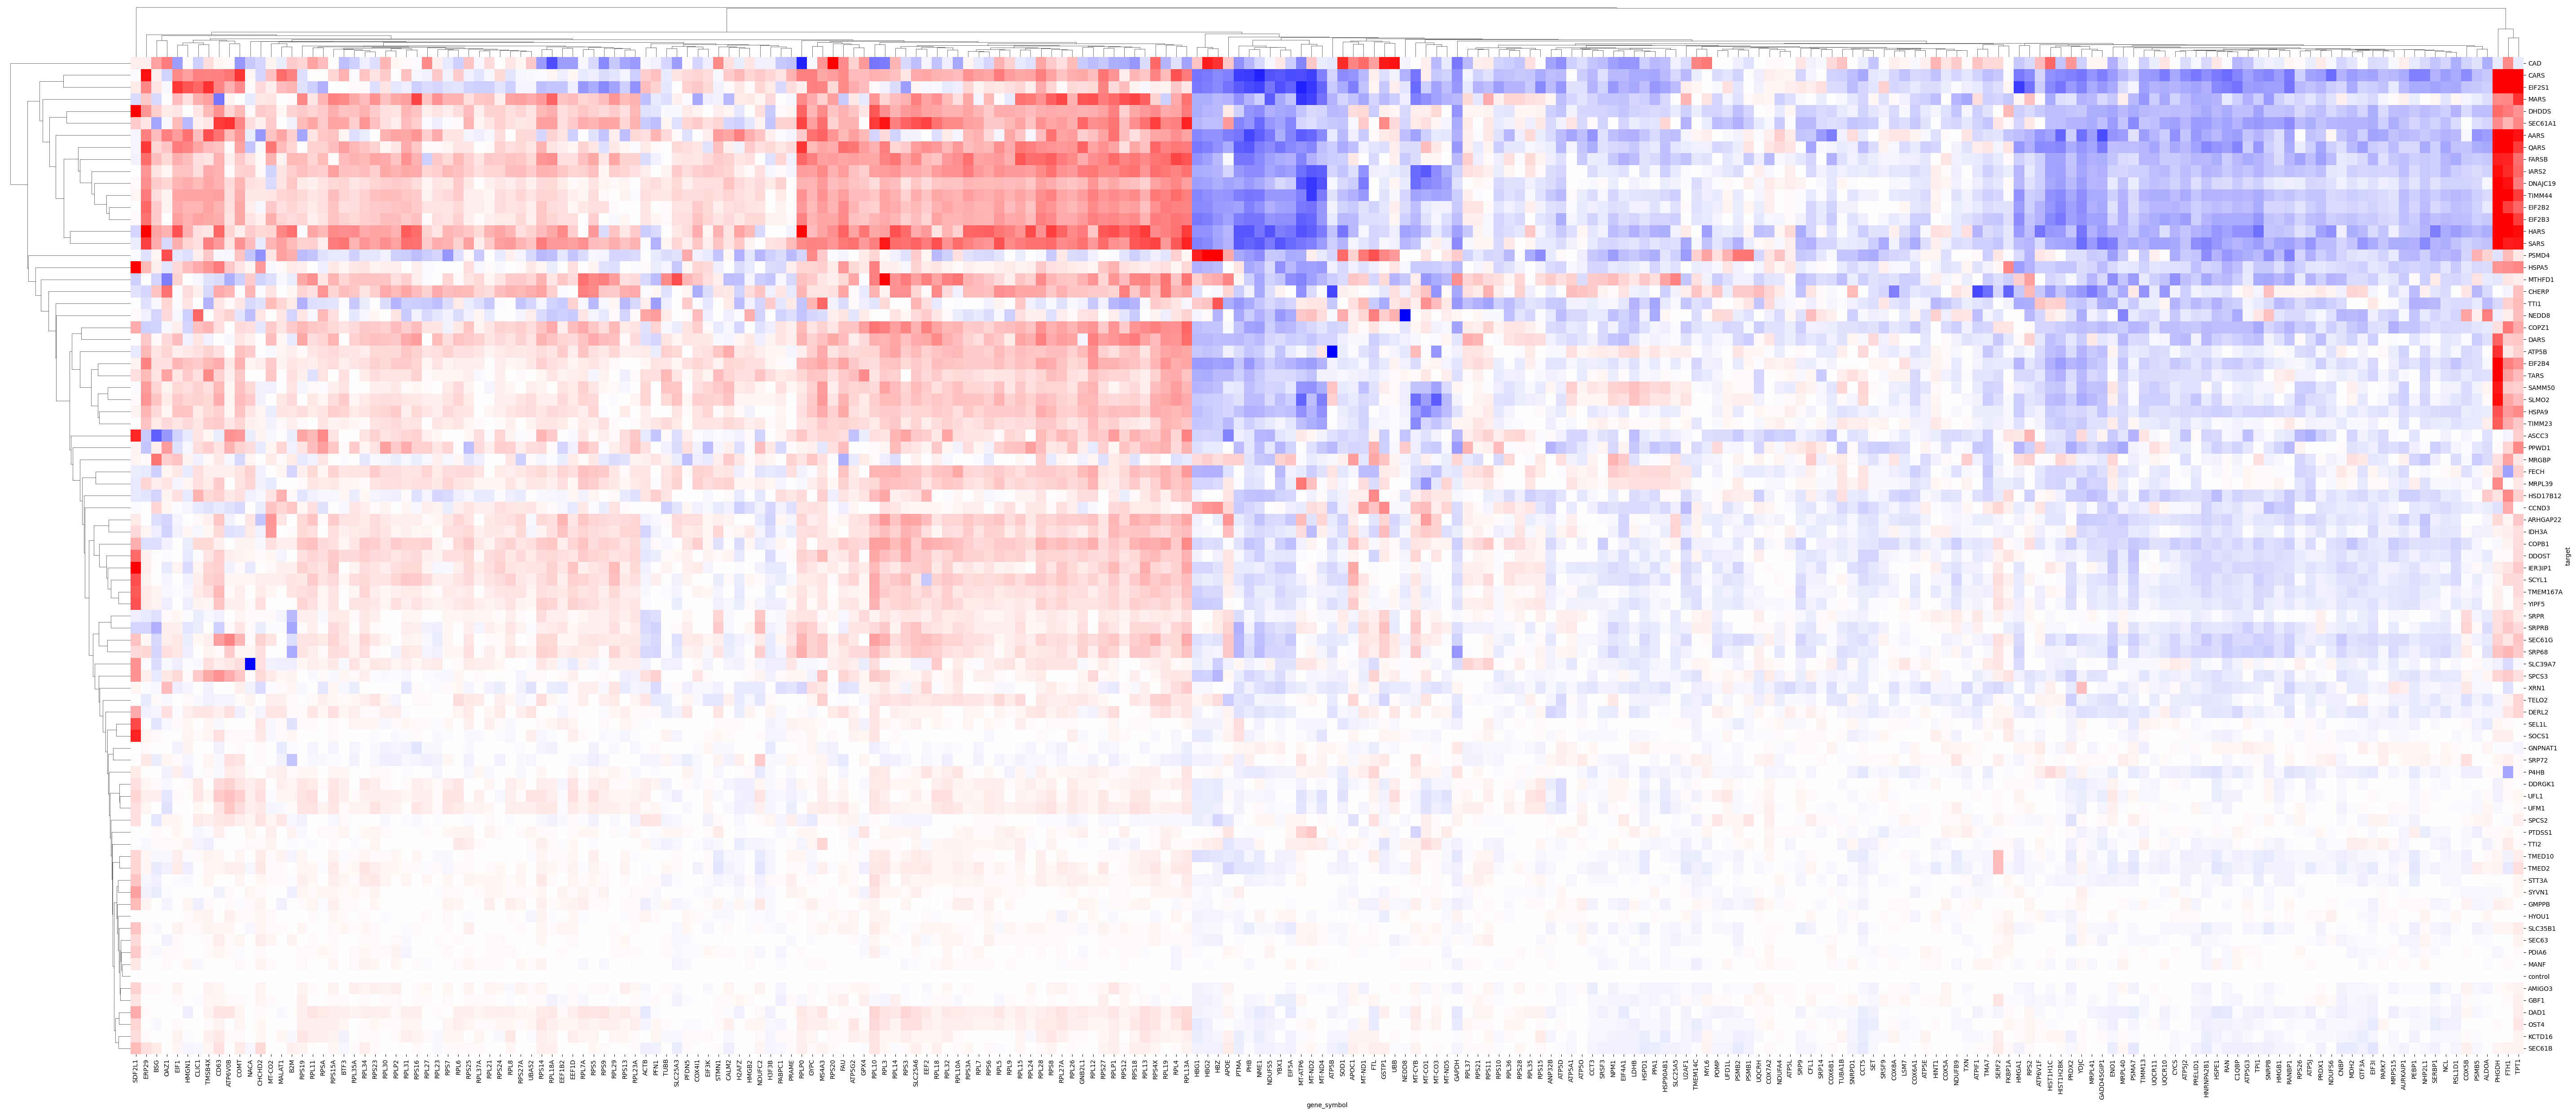

In [ ]:
sc.pl.clustermap(
    adata_pseudobulk,
    cmap="bwr",
    vmax=2,
    vmin=-2,
    figsize=(len(adata_pseudobulk.var_names) * 0.25, len(adata_pseudobulk.obs_names) * 0.3),
    dendrogram_ratio=0.05,
    cbar_pos=None
)

In [ ]:
adata_epistasis = all_adatas["GSM2406677_10X005"].copy()

In [ ]:
adata_epistasis = all_adatas["GSM2406677_10X005"].copy()
adata_epistasis.obs =  adata_epistasis.obs.rename(columns={"guide identity": "perturbation"})
annot37 = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "external_gene_name"],
    host="grch37.ensembl.org"
).set_index("ensembl_gene_id")
adata_epistasis.var["gene_symbol"] = annot37.loc[adata_epistasis.var_names]
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epistasis.var["mt"] = adata_epistasis.var["gene_symbol"].str.startswith("MT-")
# ribosomal genes
adata_epistasis.var["ribo"] = adata_epistasis.var["gene_symbol"].str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epistasis.var["hb"] = adata_epistasis.var["gene_symbol"].str.contains("^HB[^(P)]")

In [ ]:
pert = adata_epistasis.obs["perturbation"]
adata_epistasis = adata_epistasis[pert.isin(pert.value_counts()[pert.value_counts() > 14].index)].copy()

In [ ]:
# Careful, those perturbation: map to those actual genes
# IRE1 -> ERN1  and PERK -> EIF2AK3
map_gene_target = {"IRE1": "ERN1", "PERK": "EIF2AK3"}

def parse_guide(g):
    parts = [p for p in g.split("_") if p != "only"]
    if len(parts) == 1:
        parts *= 2
    raw_target = "_".join(parts[:-1])
    mapped_parts = [map_gene_target.get(p, p) for p in parts]
    target = "+".join(mapped_parts[:-1])
    plasmid = mapped_parts[-1]
    return {
        "raw_target": raw_target,
        "target": target,
        "plasmid": plasmid
    }

map_guide_id = {
    g: parse_guide(str(g)) for g in adata_epistasis.obs["perturbation"].unique()
}

adata_epistasis.obs = adata_epistasis.obs.join(
    adata_epistasis.obs["perturbation"].astype(str).to_frame().join(
        pd.DataFrame(map_guide_id).T,
        on="perturbation"
    ).drop(columns=["perturbation"])
)
adata_epistasis.obs["target"] = adata_epistasis.obs["target"].where(~adata_epistasis.obs["target"].str.contains("ctrl"), "control")
adata_epistasis.obs["target"] = adata_epistasis.obs["target"].astype("category")


In [ ]:
adata_epistasis.obs["replicate"] = adata_epistasis.obs_names.to_series().str.split("-").apply(lambda x: x[1])
adata_epistasis.obs["condition"] = adata_epistasis.obs["target"].astype(str) + "-" + adata_epistasis.obs["replicate"]

In [ ]:
adata_epistasis.layers["count"] = adata_epistasis.X
sc.pp.normalize_total(adata_epistasis)
adata_epistasis.layers["normalized"] = adata_epistasis.X

/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: Layer 'z_norm_ctrl' should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [ ]:
ctrl_mask = adata_epistasis.obs["condition"].str.contains("control-3")
ctrl_mean = adata_epistasis[ctrl_mask].X.toarray().mean(axis=0)
ctrl_std = adata_epistasis[ctrl_mask].X.toarray().std(axis=0)
ctrl_std = np.where(ctrl_std == 0, 1, ctrl_std)
adata_epistasis.layers["z_norm_ctrl"] = (adata_epistasis.X - ctrl_mean) / ctrl_std

/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: Layer 'z_norm_ctrl' should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [ ]:
# Subset to selected genes and expression layer
X = adata_epistasis[:, selected_genes.A1].layers["z_norm_ctrl"]#.toarray()

# Create a DataFrame with target labels
targets = adata_epistasis.obs["condition"].values

# Create a DataFrame of expression (cells x genes)
expr_df = pd.DataFrame(X, columns=adata_epistasis[:, selected_genes.A1].var["gene_symbol"])

# Add target as a column
expr_df["target"] = targets

# Group by target and average (mean = pseudo-bulk)
pseudobulk_expr_epistasis = expr_df.groupby("target").mean()

# Optional: reindex if you want targets in a specific order
pseudobulk_expr_epistasis = pseudobulk_expr_epistasis.sort_index()
adata_pseudobulk_epistasis = ad.AnnData(
    X=pseudobulk_expr_epistasis.values,
    obs=pd.DataFrame(index=pseudobulk_expr_epistasis.index),       # target groups as observations
    var=pd.DataFrame(index=pseudobulk_expr_epistasis.columns) # genes as variables
)

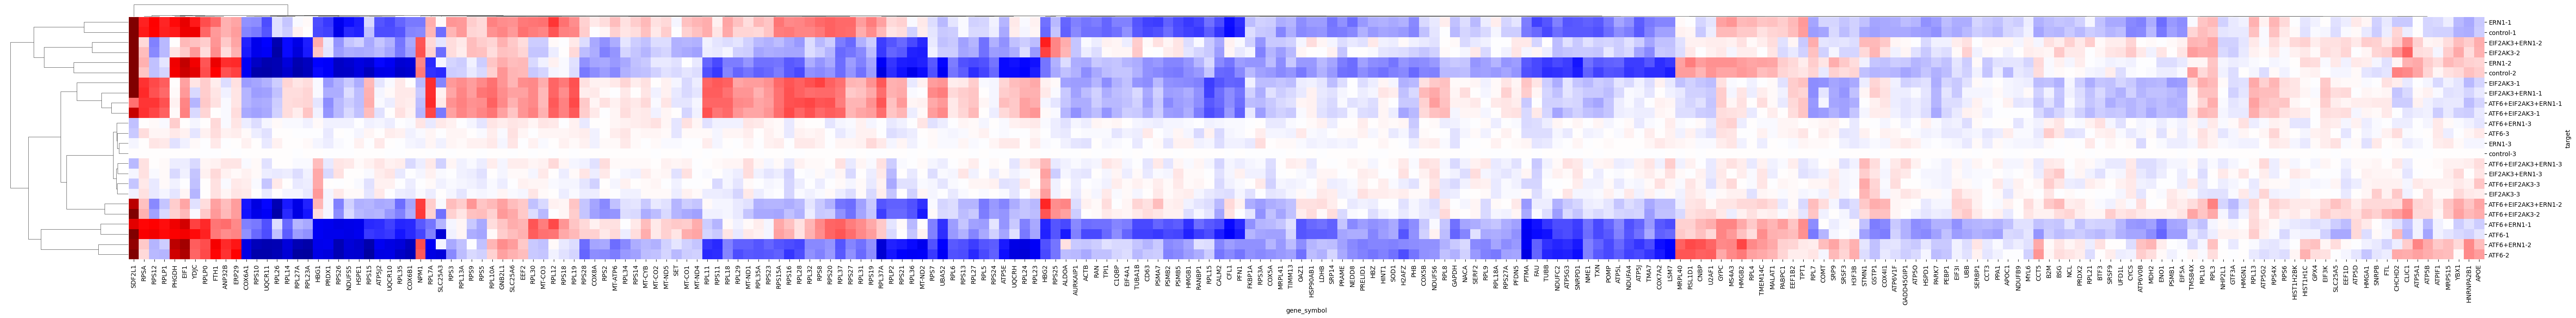

In [ ]:
sc.pl.clustermap(
    adata_pseudobulk_epistasis,
    cmap="seismic",
    vmax=2,
    vmin=-2,
    figsize=(len(adata_pseudobulk_epistasis.var_names) * 0.25, len(adata_pseudobulk_epistasis.obs_names) * 0.3),
    dendrogram_ratio=0.05,
    cbar_pos=None
)